# Understand models with global post-hoc explanations

## Imports and configuration

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from joblib import load
from lime.lime_tabular import LimeTabularExplainer
from lightgbm import plot_importance
import shap
from shap import TreeExplainer, force_plot

In [4]:
shap.initjs()

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Dataset and classifier

### Load dataset

In [6]:
data = pd.read_feather("data/heloc/heloc_preprocessed.feather")
data.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
RiskPerformance,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
ExternalRiskEstimate,55.0,61.0,67.0,66.0,81.0,59.0,54.0,68.0,59.0,61.0
MSinceOldestTradeOpen,144.0,58.0,66.0,169.0,333.0,137.0,88.0,148.0,324.0,79.0
MSinceMostRecentTradeOpen,4.0,15.0,5.0,1.0,27.0,11.0,7.0,7.0,2.0,4.0
AverageMInFile,84.0,41.0,24.0,73.0,132.0,78.0,37.0,65.0,138.0,36.0
NumSatisfactoryTrades,20.0,2.0,9.0,28.0,12.0,31.0,25.0,17.0,24.0,19.0
NumTrades60Ever2DerogPubRec,3.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
NumTrades90Ever2DerogPubRec,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
PercentTradesNeverDelq,83.0,100.0,100.0,93.0,100.0,91.0,92.0,83.0,85.0,95.0
MSinceMostRecentDelq,2.0,15.0,15.0,76.0,15.0,1.0,9.0,31.0,5.0,5.0


In [7]:
X = data.drop(columns=["RiskPerformance"])
y = data.RiskPerformance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=47)
print(X_train.shape)
print(X_test.shape)

(8883, 35)
(988, 35)


In [8]:
pd.concat([y_test, X_test], axis=1).head(10).transpose()

,9622,4927,3011,7045,5895,3993,9550,5376,9868,2622
RiskPerformance,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
ExternalRiskEstimate,80.0,78.0,78.0,81.0,66.0,75.0,58.0,63.0,74.0,86.0
MSinceOldestTradeOpen,330.0,208.0,175.0,156.0,161.0,156.0,123.0,164.0,129.0,149.0
MSinceMostRecentTradeOpen,28.0,13.0,6.0,13.0,7.0,4.0,3.0,12.0,6.0,3.0
AverageMInFile,134.0,112.0,75.0,71.0,77.0,64.0,51.0,51.0,64.0,68.0
NumSatisfactoryTrades,11.0,16.0,15.0,20.0,9.0,23.0,22.0,10.0,18.0,31.0
NumTrades60Ever2DerogPubRec,0.0,0.0,0.0,0.0,4.0,0.0,1.0,1.0,1.0,0.0
NumTrades90Ever2DerogPubRec,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0
PercentTradesNeverDelq,100.0,94.0,100.0,100.0,90.0,100.0,83.0,82.0,100.0,100.0
MSinceMostRecentDelq,15.0,3.0,15.0,15.0,79.0,15.0,2.0,24.0,15.0,15.0


### Load pre-trained classifier

In [9]:
lgb = load("models/heloc_lgb_skl.joblib")
lgb

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.7, importance_type='split', learning_rate=0.1,
               max_depth=5, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [10]:
roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])

0.8217571712069277

## SHAP for global prediction explanations

In [11]:
shap_explainer = TreeExplainer(lgb, X_train, model_output="probability")

In [12]:
shap_values = np.array(shap_explainer.shap_values(X_test))

100%|===================| 987/988 [04:14<00:00]        

### Summary plots

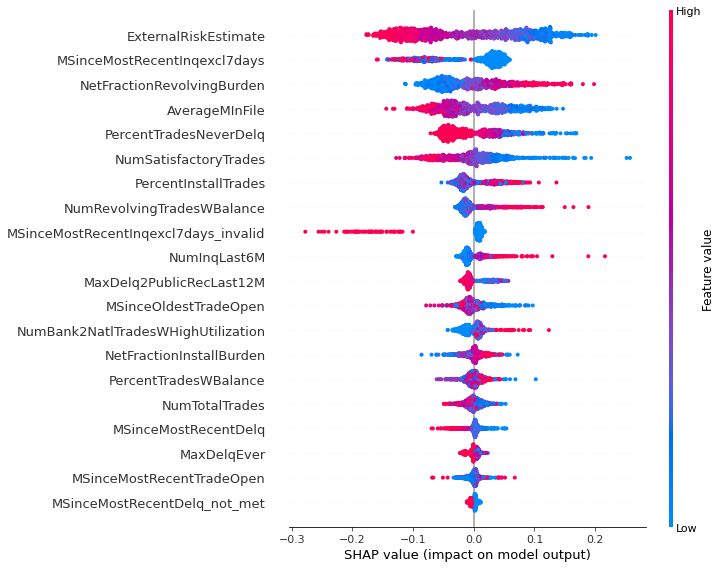

In [17]:
shap.summary_plot(shap_values, X_test)

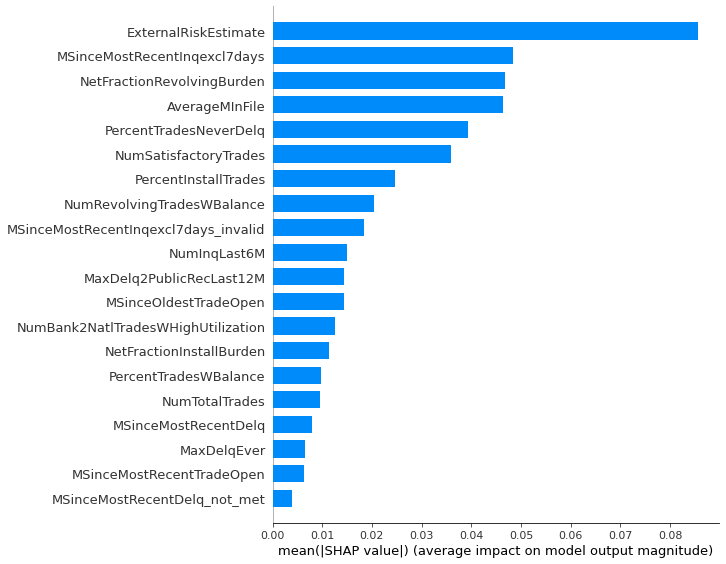

In [18]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Dependence plots

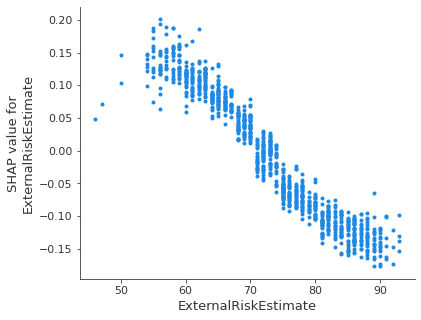

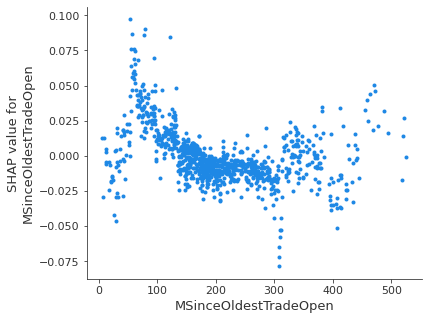

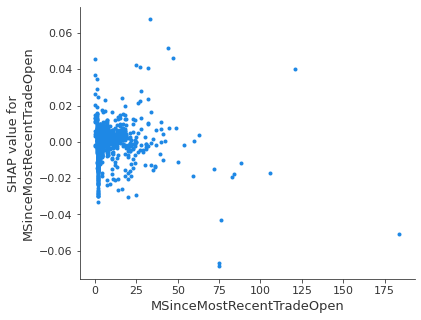

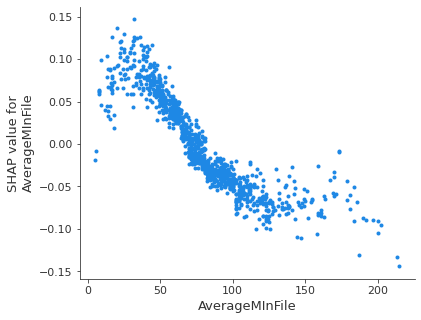

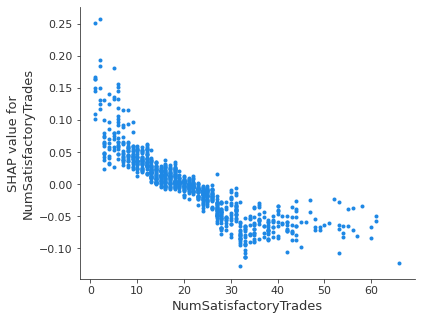

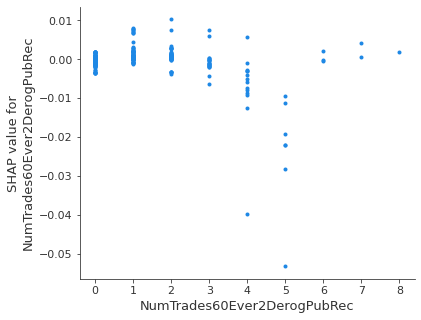

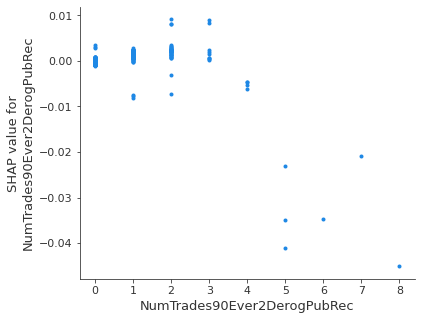

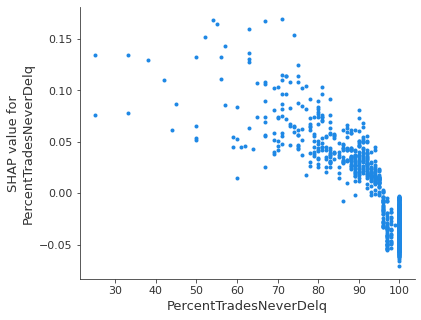

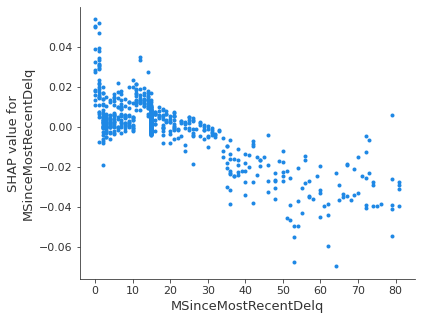

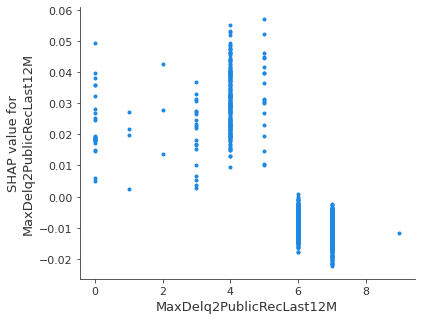

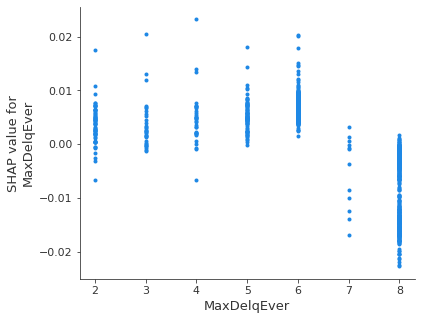

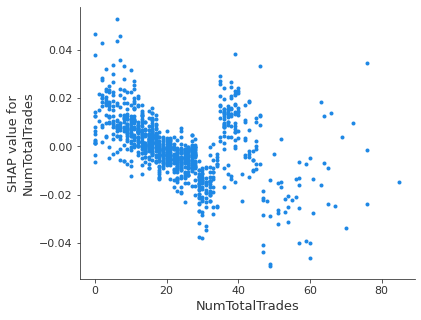

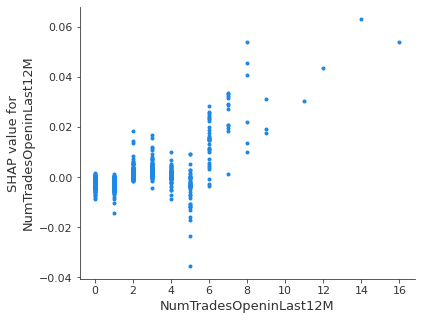

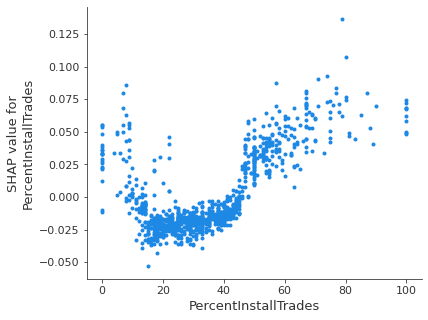

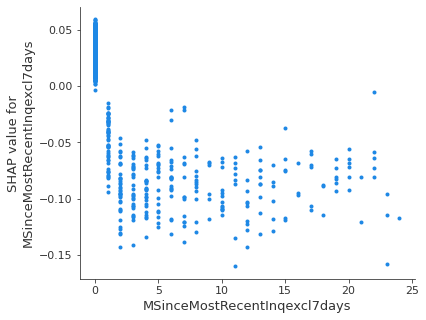

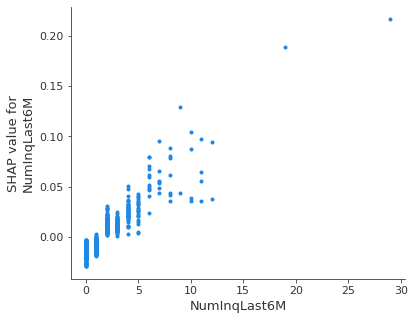

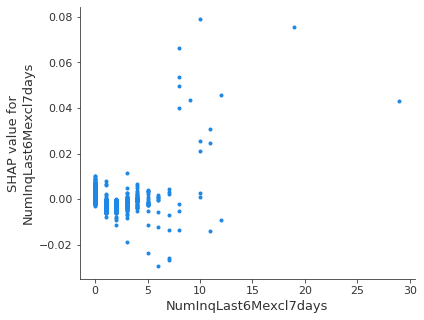

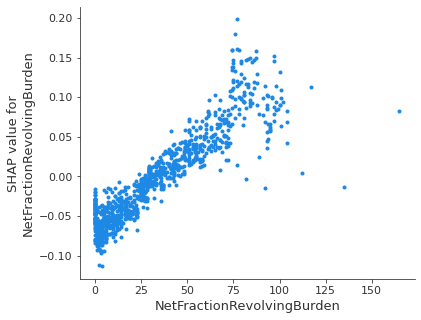

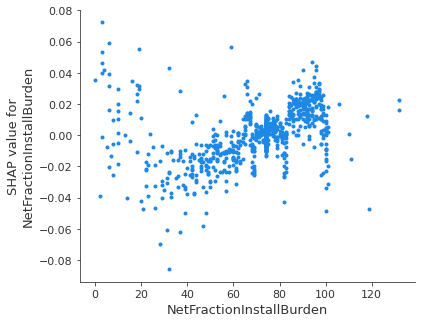

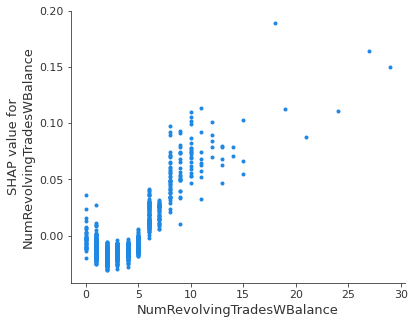

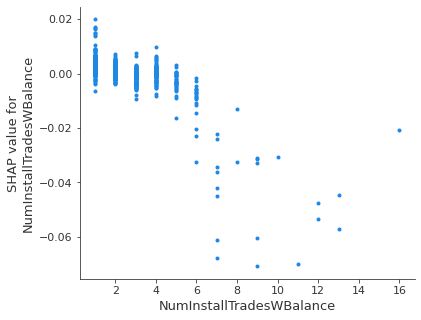

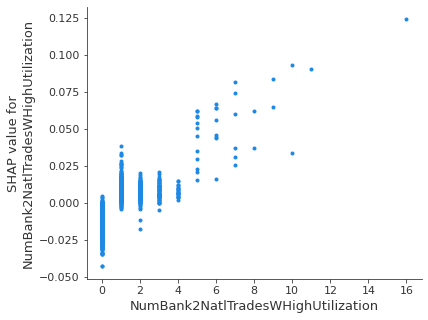

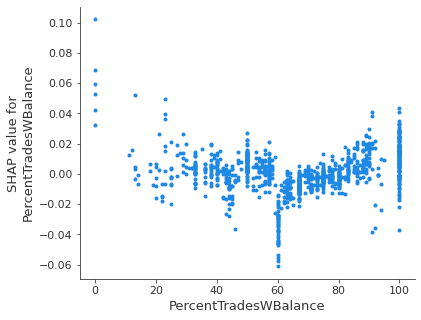

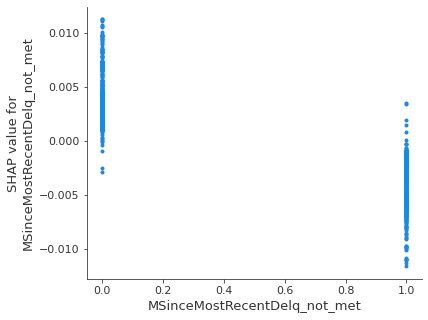

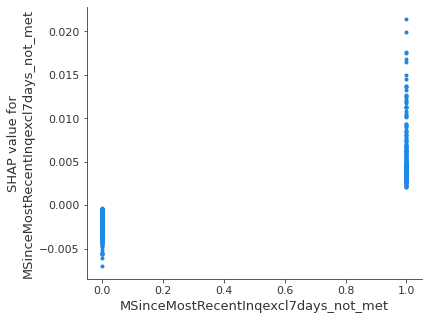

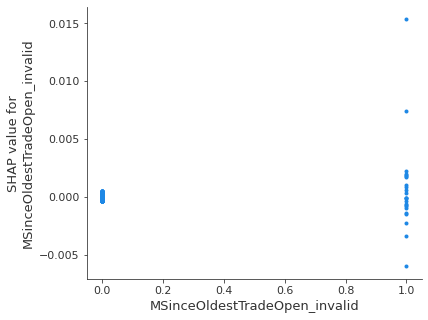

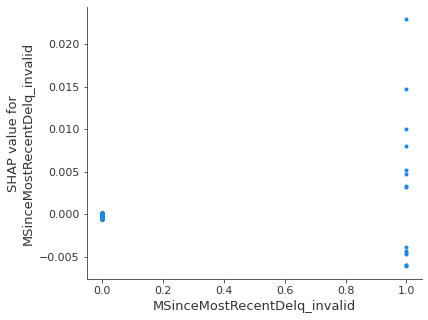

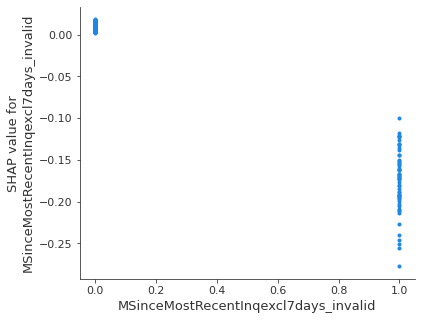

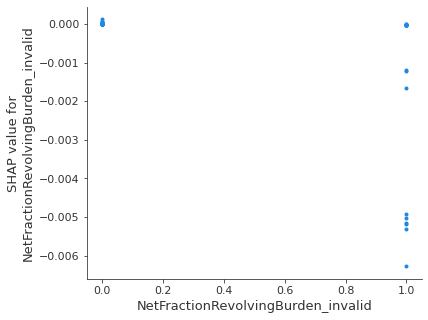

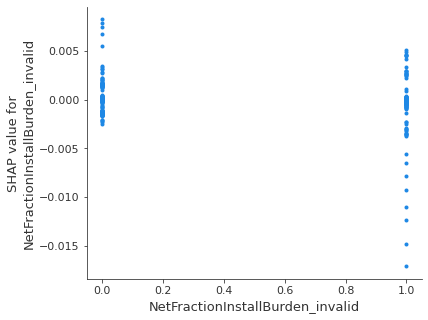

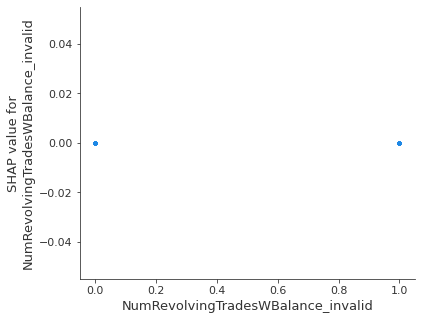

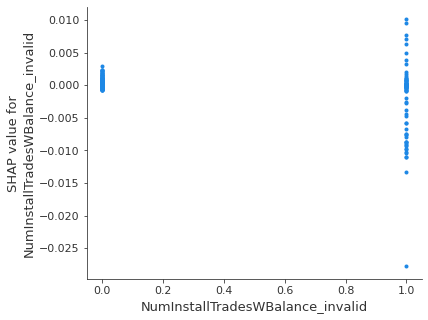

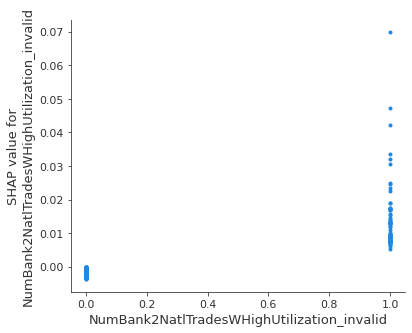

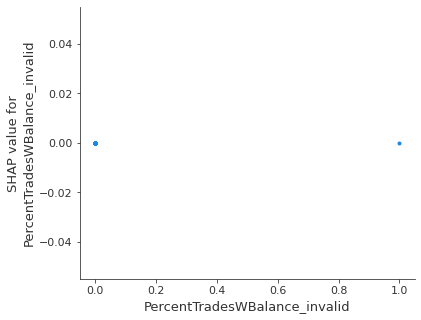

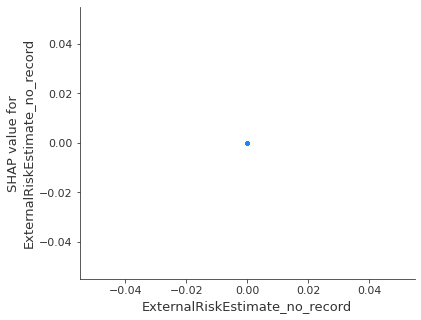

In [23]:
for col in X_test.columns:
    shap.dependence_plot(col, shap_values, X_test, interaction_index=None)